In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import mode
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set_style('whitegrid')

In [ ]:
path = "/content/mcdonalds.csv"
data = pd.read_csv(path)
data

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Yes,I hate it!-5,47,Once a year,Male
1449,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,+2,36,Once a week,Female
1450,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,No,No,+3,52,Once a month,Female
1451,Yes,Yes,No,No,No,Yes,Yes,Yes,No,Yes,No,+4,41,Every three months,Male


In [ ]:
data.columns

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')

In [ ]:
data.shape

(1453, 15)

In [ ]:
data.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


In [ ]:
matrix = data.iloc[:,0:11]
matrix = matrix.applymap(lambda x : 1 if x == 'Yes' else 0)
average_matrix = matrix.apply(np.mean, axis = 0)
np.round(average_matrix,2)

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64

In [ ]:
def pca_summary(data, n_components):
  pca_list = []

  for i in range(1,n_components+1):
    pca_model = PCA(n_components = i)
    pca_model.fit(data)

    pca_list.append(pd.Series({
        'n' : i,
        'model' : pca_model,
        'Variance' : pca_model.explained_variance_ratio_[-1],
        'Cumulative_Variance' : pca_model.explained_variance_ratio_.sum(),
        'Standard_Deviation' : np.sqrt(pca_model.explained_variance_ratio_[-1])
    }))

  pca_report = pd.DataFrame(pd.concat(pca_list, axis=1).T.set_index('n'))
  return pca_report

pca_summary(matrix, 11)

,model,Variance,Cumulative_Variance,Standard_Deviation
n,,,,
1,PCA(n_components=1),0.299447,0.299447,0.547218
2,PCA(n_components=2),0.192797,0.492244,0.439087
3,PCA(n_components=3),0.133045,0.62529,0.364754
4,PCA(n_components=4),0.083096,0.708386,0.288263
5,PCA(n_components=5),0.059481,0.767866,0.243886
6,PCA(n_components=6),0.0503,0.818166,0.224276
7,PCA(n_components=7),0.043849,0.862015,0.209402
8,PCA(n_components=8),0.039548,0.901563,0.198866
9,PCA(n_components=9),0.036761,0.938323,0.191731


In [ ]:
pca_result = pca_summary(matrix, 11)
pca_component_std = pca_result['Standard_Deviation'].map(lambda x : np.round(x , 2))
pca_component_std


n
1     0.55
2     0.44
3     0.36
4     0.29
5     0.24
6     0.22
7     0.21
8     0.20
9     0.19
10    0.18
11    0.17
Name: Standard_Deviation, dtype: float64

In [ ]:
def component_weightage(data, n_components):
  feature_weight_list = []

  for i in range(1,n_components+1):
    PCAmod = PCA(n_components = i)
    PCAmod.fit(data)
    weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
    overall_contributions = np.abs(PCAmod.components_) * weights
    abs_feature_values = overall_contributions.sum(axis=0)
    feature_weight_list.append(pd.DataFrame({
            'n': i,
            'features': data.columns,
            'values': abs_feature_values / abs_feature_values.sum(),
        }))

  feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')
  return feature_importance_report

component_weightage(matrix, 11)


features,cheap,convenient,disgusting,expensive,fast,fattening,greasy,healthy,spicy,tasty,yummy
n,,,,,,,,,,,
1,0.116512,0.053674,0.129493,0.113698,0.037489,0.040163,0.105198,0.073846,0.002196,0.162928,0.164801
2,0.166465,0.037813,0.105912,0.163237,0.037492,0.031496,0.078760,0.059951,0.004209,0.152571,0.162093
3,0.146860,0.035702,0.092912,0.134018,0.035616,0.051875,0.129415,0.064216,0.006436,0.146921,0.156030
4,0.136078,0.038247,0.099484,0.122325,0.036120,0.062272,0.126701,0.091882,0.014720,0.130835,0.141334
5,0.129487,0.043653,0.113758,0.113008,0.036587,0.059688,0.127821,0.093469,0.015712,0.127111,0.139708
6,0.122996,0.048875,0.110901,0.111397,0.048140,0.065194,0.123957,0.091239,0.023034,0.120160,0.134109
7,0.117980,0.047741,0.106188,0.107479,0.047573,0.069703,0.118812,0.093803,0.035861,0.121571,0.133289
8,0.115460,0.047680,0.104619,0.103516,0.056269,0.076830,0.116226,0.092904,0.040762,0.117759,0.127975
9,0.112467,0.046247,0.101961,0.100814,0.056777,0.076512,0.112090,0.092389,0.045393,0.123259,0.132091


In [ ]:
pca_model = PCA(n_components = 2)
pca_model.fit(matrix)
pca_model.components_

array([[-0.47693349, -0.15533159, -0.00635636,  0.11623168,  0.3044427 ,
        -0.10849325, -0.33718593, -0.47151394,  0.32904173, -0.21371062,
         0.37475293],
       [ 0.36378978,  0.016414  ,  0.01880869, -0.03409395, -0.06383884,
        -0.0869722 , -0.61063276,  0.3073178 ,  0.60128596,  0.07659344,
        -0.13965633]])

In [ ]:
components_coordinates = []
for i in range(11):
  coordinates = [pca_model.components_[0][i] ,pca_model.components_[1][i]]
  components_coordinates.append(coordinates)

pd.DataFrame(zip(matrix.columns, components_coordinates))


,0,1
0,yummy,"[-0.4769334897676289, 0.36378978348877344]"
1,convenient,"[-0.1553315899000498, 0.016413997341583275]"
2,spicy,"[-0.0063563615994714, 0.018808693980576566]"
3,fattening,"[0.11623168402351368, -0.0340939542596631]"
4,greasy,"[0.3044426959919977, -0.06383884110153108]"
5,fast,"[-0.10849325331734183, -0.08697220385838157]"
6,cheap,"[-0.3371859251110035, -0.6106327608864018]"
7,tasty,"[-0.4715139424728062, 0.307317800092565]"
8,expensive,"[0.32904173176005136, 0.6012859578332348]"
9,healthy,"[-0.21371062049692513, 0.07659343526691884]"


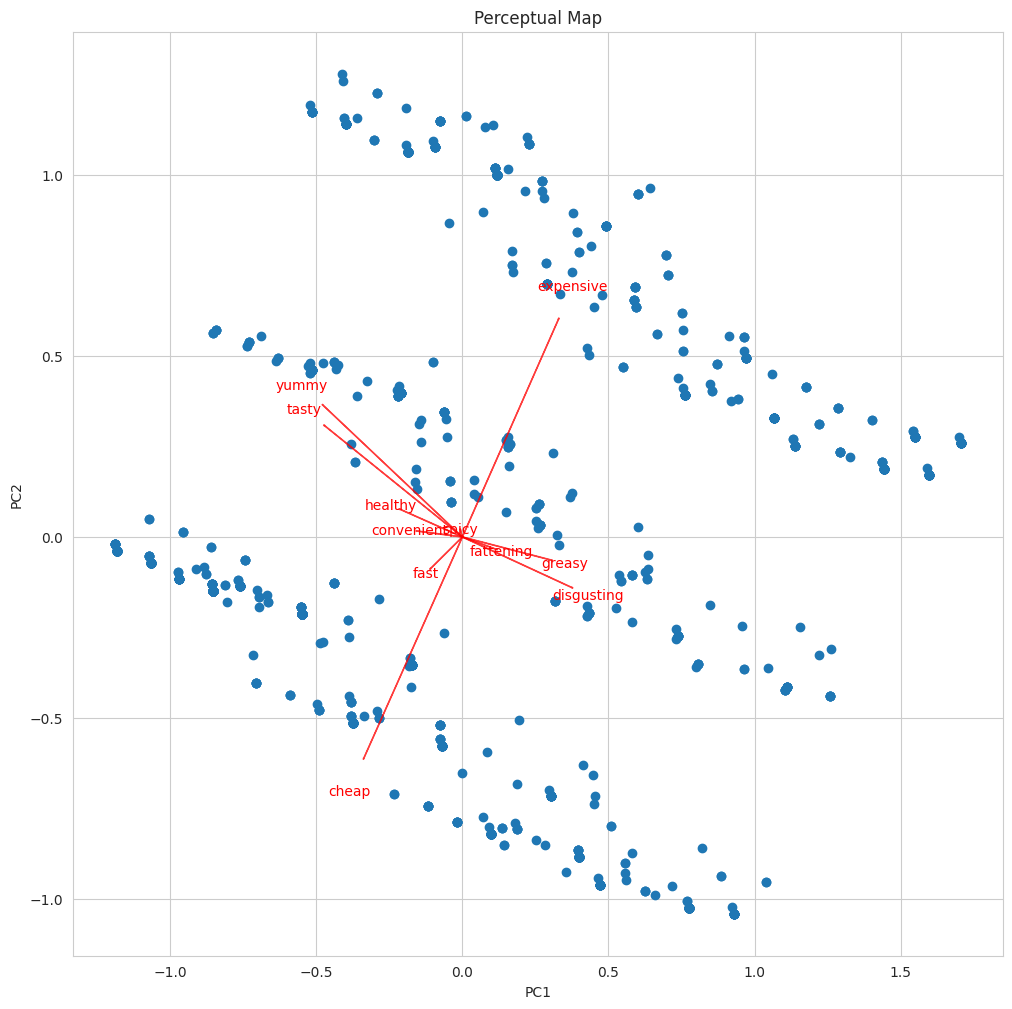

In [ ]:
pca_model = PCA(n_components = 2)
pca_result = pca_model.fit_transform(matrix)
plt.figure(figsize = (12,12))
plt.title('Perceptual Map')
plt.scatter(pca_result[:,0] , pca_result[:,1])
for i, (var, coef) in enumerate(zip(matrix.columns, components_coordinates)):
        plt.arrow(0, 0, coef[0], coef[1], color='r', alpha=0.7)
        plt.text(coef[0] * 1.15, coef[1] * 1.15, var, color='r', ha='center', va='center')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

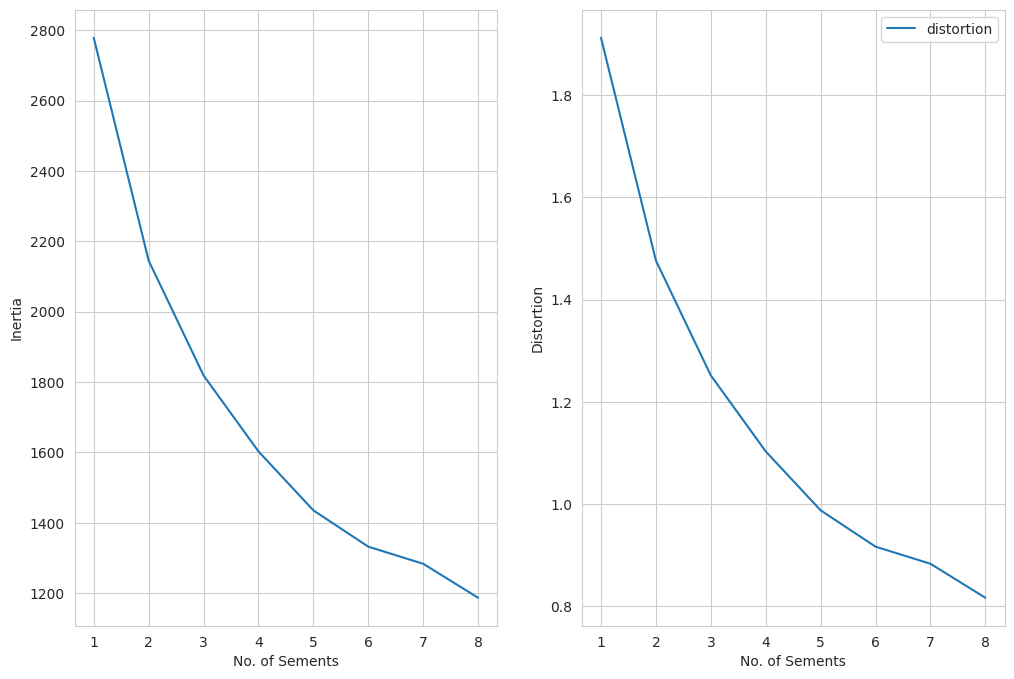

In [ ]:
cluster_range = np.arange(1,9)
labels_true = []
inertia = []
for i in cluster_range:
  km = KMeans(n_clusters = i)
  km.fit(matrix)
  inertia.append(km.inertia_)
  labels_true.append(km.labels_)

distortion = [inertia[i] / matrix.shape[0] for i in range(len(inertia))]

fig,ax = plt.subplots(figsize = (12,8),nrows = 1 , ncols = 2)
ax[0].plot(cluster_range,inertia,label = 'inertia')
ax[0].set_ylabel('Inertia')
ax[0].set_xlabel('No. of Sements')
ax[1].plot(cluster_range,distortion, label = 'distortion')
ax[1].set_ylabel('Distortion')
ax[1].set_xlabel('No. of Sements')
plt.legend()
plt.show()



Text(0, 0.5, 'Sum of within clusters')

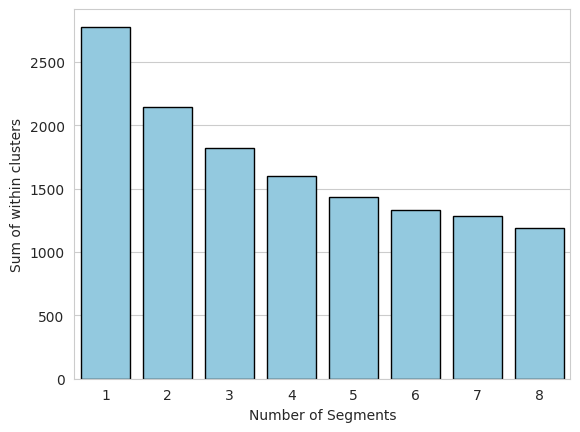

In [ ]:
sns.barplot(x= cluster_range, y=inertia, color='skyblue', edgecolor='black')
plt.xlabel('Number of Segments')
plt.ylabel('Sum of within clusters')

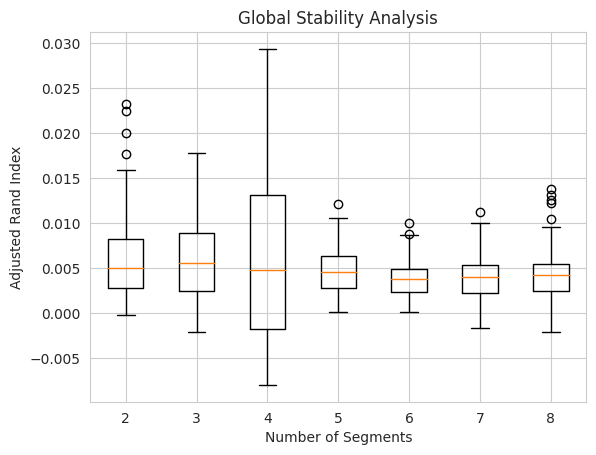

In [ ]:
# Set seed for reproducibility
np.random.seed(1234)

# Number of segments (clusters) to consider
num_segments_range = np.arange(2, 9)

# Number of bootstrap samples
nboot = 100

# Number of random initializations for k-means
nrep = 10

# Function to calculate adjusted Rand index for clustering
def calculate_adjusted_rand_index(labels_true, labels_pred):
    return adjusted_rand_score(labels_true, labels_pred)

def bootstrap_stability_analysis(data, num_segments, nboot, nrep):
  stability_scores = []
  # Store labels_pred from each bootstrap
  all_labels = []

  for _ in range(nboot):

      # Bootstrap sample
      bootstrap_sample = resample(data, replace=True)

      # K-means
      kmeans = KMeans(n_clusters=num_segments, n_init=nrep)
      labels_pred = kmeans.fit_predict(bootstrap_sample)

      # Store labels_pred
      all_labels.append(labels_pred)

  # Get labels_true as mode across all bootstraps
  stacked = np.stack(all_labels)
  labels_true = mode(stacked, axis=0).mode

  for labels_pred in all_labels:

      # Calculate ARI for each bootstrap
      ari = calculate_adjusted_rand_index(labels_true, labels_pred)
      stability_scores.append(ari)

  return np.array(stability_scores)

stability_results = []

for num_segments in num_segments_range:
  stability_scores = bootstrap_stability_analysis(matrix, num_segments, nboot, nrep)
  stability_results.append(stability_scores)

plt.boxplot(stability_results, labels=num_segments_range)
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability Analysis')
plt.show()

In [ ]:
# fig, ax = plt.subplots()

# bp = ax.boxplot(stability_results, labels=num_segments_range, showmeans=False)
# modes = [mode(scores, axis=None).mode[0] if isinstance(scores, np.ndarray) else scores
#          for scores in stability_results]

# mode_positions = [item.get_xdata()[0] for item in bp['fliers'][0]]

# for mode, position in zip(modes, mode_positions):
#   ax.hlines(mode, position - 0.2, position + 0.2, color='red', label='Mode')

# plt.xlabel('Number of Segments')
# plt.ylabel('Adjusted Rand Index')
# plt.title('Global Stability Analysis')

# plt.legend()
# plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


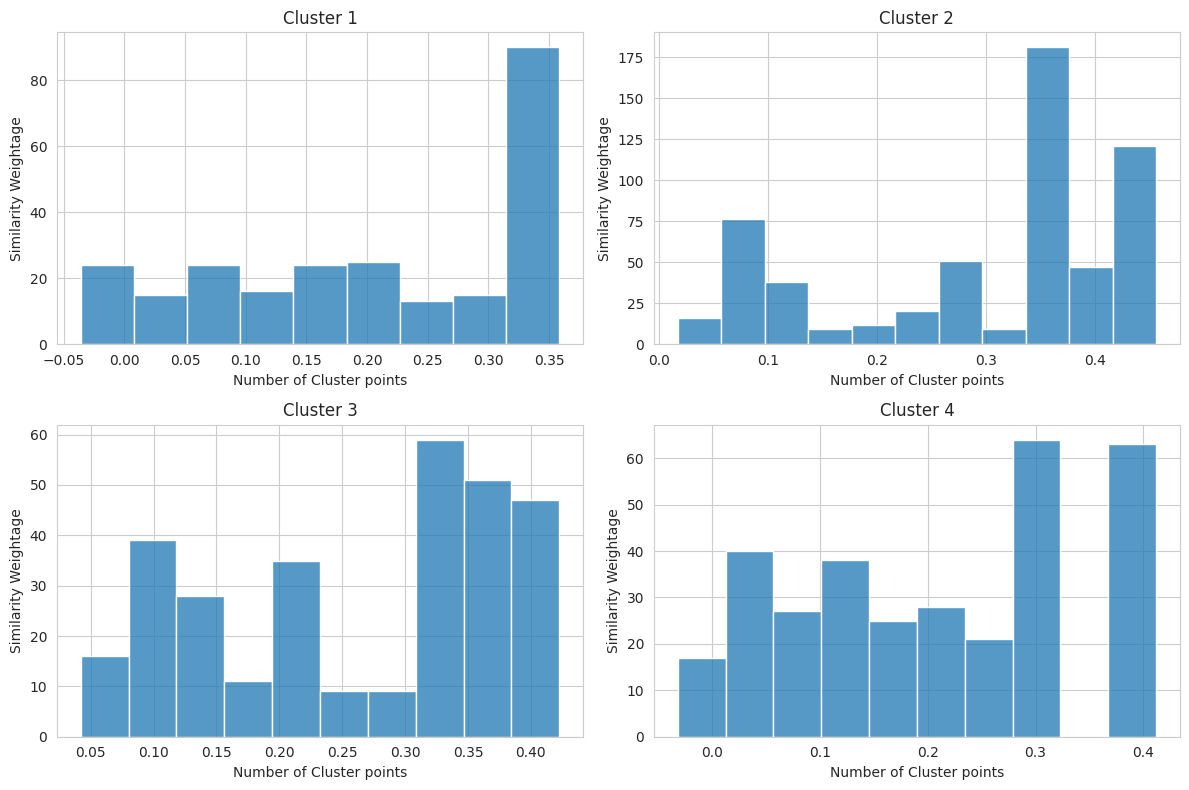

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 123)
labels = kmeans.fit_predict(matrix)

silhouette_avg = silhouette_score(matrix,labels)
sample_silhouette_values = silhouette_samples(matrix, labels)
fig,ax = plt.subplots(figsize = (12,8), nrows = 2, ncols = 2)

plt.title('Gorge Plot for 4 selected Segments or Clusters using Global Stability')

first_cluster_silhouette_values = sample_silhouette_values[labels == 0]
first_cluster_silhouette_values.sort()

ax[0][0].set_title('Cluster 1')
ax[0][0].set_xlabel('Number of Cluster points')
ax[0][0].set_ylabel('Similarity Weightage')

sns.histplot(first_cluster_silhouette_values,ax = ax[0][0])

second_cluster_silhouette_values = sample_silhouette_values[labels == 1]
second_cluster_silhouette_values.sort()

ax[0][1].set_title('Cluster 2')
ax[0][1].set_xlabel('Number of Cluster points')
ax[0][1].set_ylabel('Similarity Weightage')

sns.histplot(second_cluster_silhouette_values,ax = ax[0][1])

third_cluster_silhouette_values = sample_silhouette_values[labels == 2]
third_cluster_silhouette_values.sort()

ax[1][0].set_title('Cluster 3')
ax[1][0].set_xlabel('Number of Cluster points')
ax[1][0].set_ylabel('Similarity Weightage')

sns.histplot(third_cluster_silhouette_values,ax = ax[1][0])

fourth_cluster_silhouette_values = sample_silhouette_values[labels == 3]
fourth_cluster_silhouette_values.sort()

ax[1][1].set_title('Cluster 4')
ax[1][1].set_xlabel('Number of Cluster points')
ax[1][1].set_ylabel('Similarity Weightage')

sns.histplot(fourth_cluster_silhouette_values,ax = ax[1][1])
plt.tight_layout()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

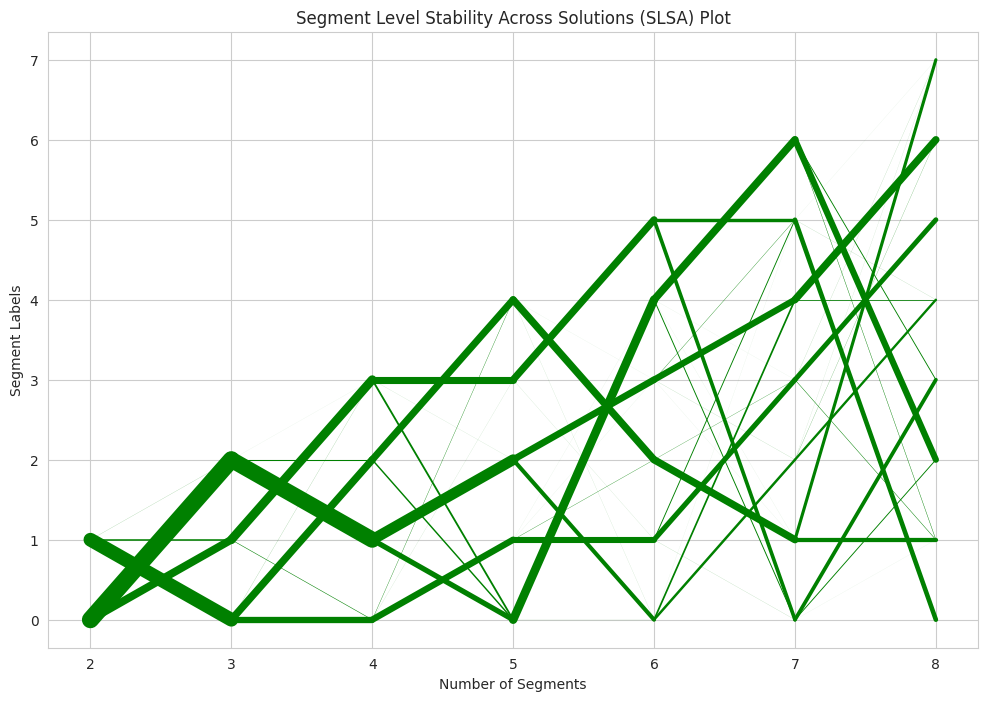

In [ ]:
#identifying natural segment across solutions

num_clusters_range = range(2,9)
cluster_results = []

for num_cluster in num_clusters_range:
  kmeans_model = KMeans(n_clusters = num_cluster, random_state = 123)
  labels = kmeans_model.fit_predict(matrix)
  cluster_results.append(labels)

fig,ax = plt.subplots(figsize = (12,8))
for i in range(len(num_clusters_range) - 1):
    current_labels = cluster_results[i]
    next_labels = cluster_results[i + 1]

    # Count the occurrences of each label pair
    label_pairs, counts = np.unique((current_labels, next_labels), axis=1, return_counts=True)

    for label_pair, count in zip(label_pairs.T, counts):
        ax.plot([i, i + 1], label_pair, linewidth=count/50, color='green')

ax.set_xticks(range(len(num_clusters_range)))
ax.set_xticklabels(num_clusters_range)
ax.set_xlabel('Number of Segments')
ax.set_ylabel('Segment Labels')
ax.set_title('Segment Level Stability Across Solutions (SLSA) Plot')

plt.show()



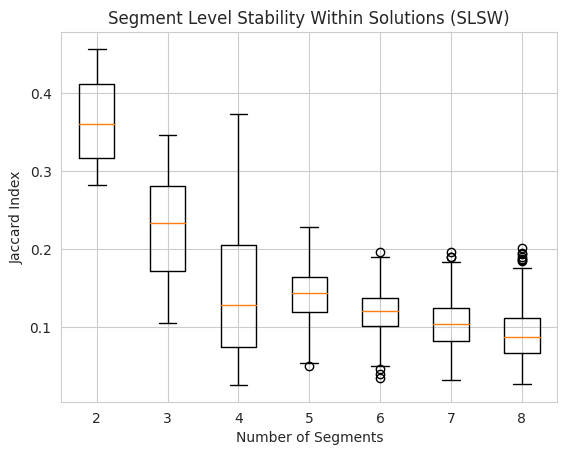

In [ ]:
# Set seed for reproducibility
np.random.seed(1234)

# Function to calculate Jaccard index
def jaccard_index(seg1, seg2):
    intersection = np.sum(np.logical_and(seg1, seg2))
    union = np.sum(np.logical_or(seg1, seg2))
    return intersection / union if union != 0 else 0

# Function to calculate Segment Level Stability Within Solutions (SLSW)
def slsw(data, k, nboot, nrep):
    all_segments = []

    for _ in range(nboot):
        bootstrap_sample = resample(data, replace=True)
        kmeans = KMeans(n_clusters=k, n_init=nrep)
        labels_pred = kmeans.fit_predict(bootstrap_sample)
        all_segments.append(labels_pred)

    # Get labels_true as mode across all bootstraps
    stacked = np.stack(all_segments)
    labels_true = mode(stacked, axis=0).mode

    # Calculate Jaccard index for each segment
    jaccard_indices = []

    for i in range(k):
        jaccard_values = []
        for j in range(nboot):
            jaccard_values.append(jaccard_index(labels_true == i, all_segments[j] == i))
        jaccard_indices.append(jaccard_values)

    return np.array(jaccard_indices)

# Example usage with an artificial dataset

num_segments_range = np.arange(2, 9)
nboot = 100
nrep = 10

# Calculate SLSW for each number of segments
slsw_results = []

for num_segments in num_segments_range:
    slsw_values = slsw(matrix, num_segments, nboot, nrep)
    slsw_results.append(slsw_values)

# Flatten the 2D arrays within slsw_results
flattened_results = [arr.flatten() for arr in slsw_results]

# Plot boxplots for flattened SLSW values
plt.boxplot(flattened_results, labels=num_segments_range)
plt.xlabel('Number of Segments')
plt.ylabel('Jaccard Index')
plt.title('Segment Level Stability Within Solutions (SLSW)')
plt.show()

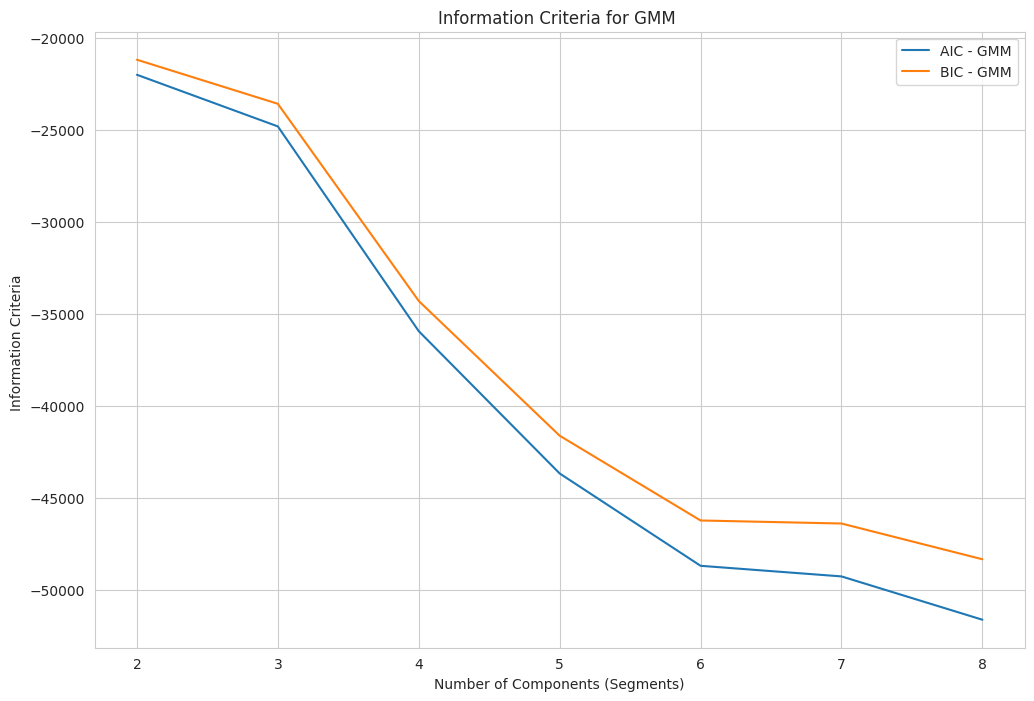

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler


# Number of components (segments) to consider
num_components_range = range(2, 9)

# Number of random restarts for Gaussian Mixture Model
n_init = 10

# Perform Gaussian Mixture Model with varying number of components
gm_results = {'AIC': [], 'BIC': []}

for num_components in num_components_range:
    gmm = GaussianMixture(n_components=num_components, n_init=n_init, random_state=1234)
    gmm.fit(matrix)
    gm_results['AIC'].append(gmm.aic(matrix))
    gm_results['BIC'].append(gmm.bic(matrix))

# Plotting the Information Criteria
fig, ax = plt.subplots(figsize=(12, 8))

for criterion, label in zip(['AIC', 'BIC'], ['AIC', 'BIC']):
    ax.plot(num_components_range,gm_results[criterion],  label=f'{label} - GMM')


ax.set_xlabel('Number of Components (Segments)')
ax.set_ylabel('Information Criteria ')
ax.legend()
plt.title('Information Criteria for GMM ')
plt.show()


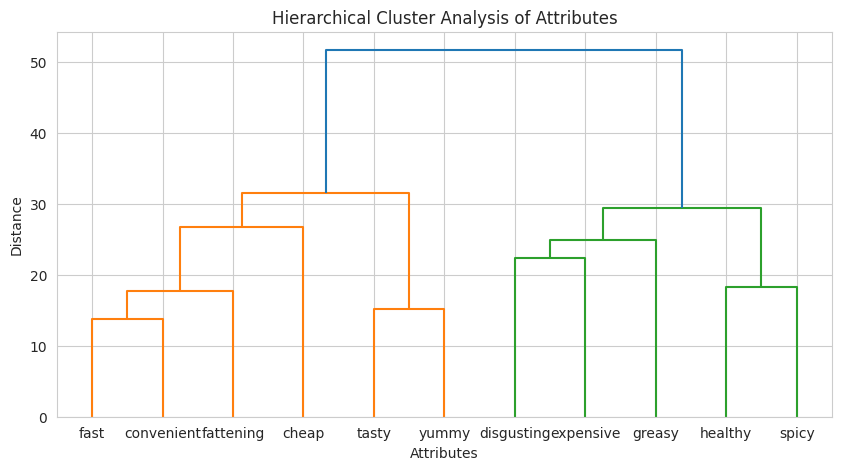

In [ ]:
# Calculate hierarchical clustering
MD_vclust = linkage(matrix.T, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 5))
dendrogram(MD_vclust, labels=matrix.columns, orientation='top', leaf_font_size=10, distance_sort='descending')
plt.title('Hierarchical Cluster Analysis of Attributes')
plt.xlabel('Attributes')
plt.ylabel('Distance')
plt.show()

In [ ]:
num_segments = 4
n_rep = 10
kmeans_model = KMeans(n_clusters = num_segments, random_state = 123, n_init= n_rep)
labels = kmeans_model.fit_predict(matrix)

matrix['labels'] = pd.Series(labels)
matrix

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,labels
0,0,1,0,1,0,1,1,0,1,0,0,2
1,1,1,0,1,1,1,1,1,1,0,0,3
2,0,1,1,1,1,1,0,1,1,1,0,3
3,1,1,0,1,1,1,1,1,0,0,1,1
4,0,1,0,1,1,1,1,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1448,0,1,0,1,1,0,0,0,1,0,1,0
1449,1,1,0,1,0,0,1,1,0,1,0,1
1450,1,1,0,1,0,1,0,1,1,0,0,3
1451,1,1,0,0,0,1,1,1,0,1,0,1


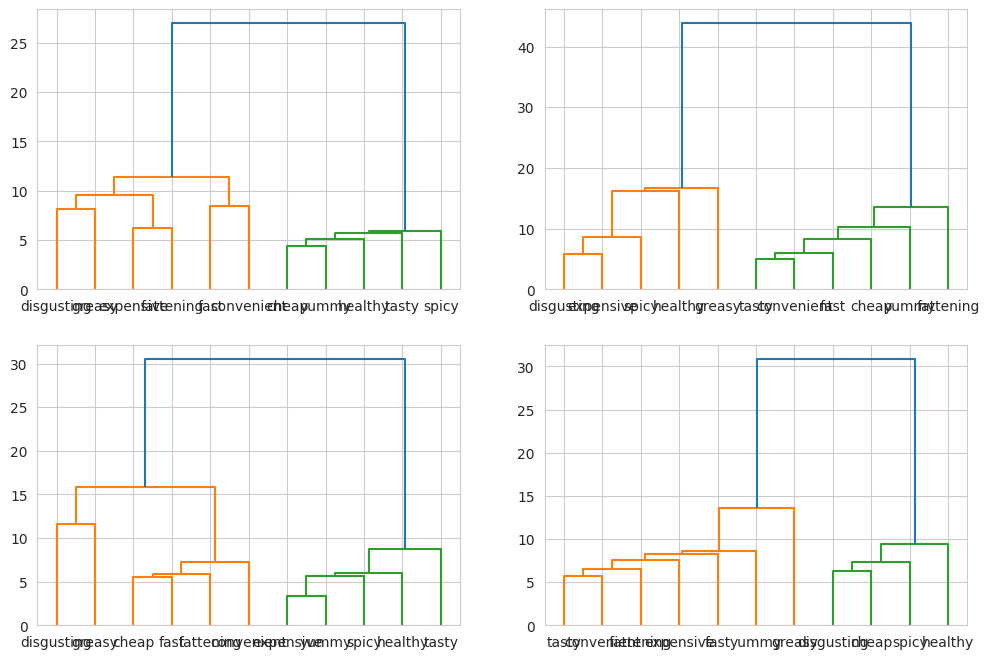

In [ ]:
cluster_0 = matrix[matrix['labels'] == 0].drop(columns = ['labels'])
cluster_1 = matrix[matrix['labels'] == 1].drop(columns = ['labels'])
cluster_2 = matrix[matrix['labels'] == 2].drop(columns = ['labels'])
cluster_3 = matrix[matrix['labels'] == 3].drop(columns = ['labels'])


#hierachical_clustering of cluster_1 data samples
cluster_0_linkage = linkage(cluster_0.T, method='ward')
cluster_1_linkage = linkage(cluster_1.T, method='ward')
cluster_2_linkage = linkage(cluster_2.T, method='ward')
cluster_3_linkage = linkage(cluster_3.T, method='ward')

fig,ax = plt.subplots(figsize = (12,8),nrows = 2, ncols = 2)
dendrogram(cluster_0_linkage, labels=cluster_0.columns, orientation='top', leaf_font_size=10, distance_sort='descending', ax = ax[0][0])
dendrogram(cluster_1_linkage, labels=cluster_1.columns, orientation='top', leaf_font_size=10, distance_sort='descending', ax = ax[0][1])
dendrogram(cluster_2_linkage, labels=cluster_2.columns, orientation='top', leaf_font_size=10, distance_sort='descending', ax = ax[1][0])
dendrogram(cluster_3_linkage, labels=cluster_3.columns, orientation='top', leaf_font_size=10, distance_sort='descending', ax = ax[1][1])

plt.show()

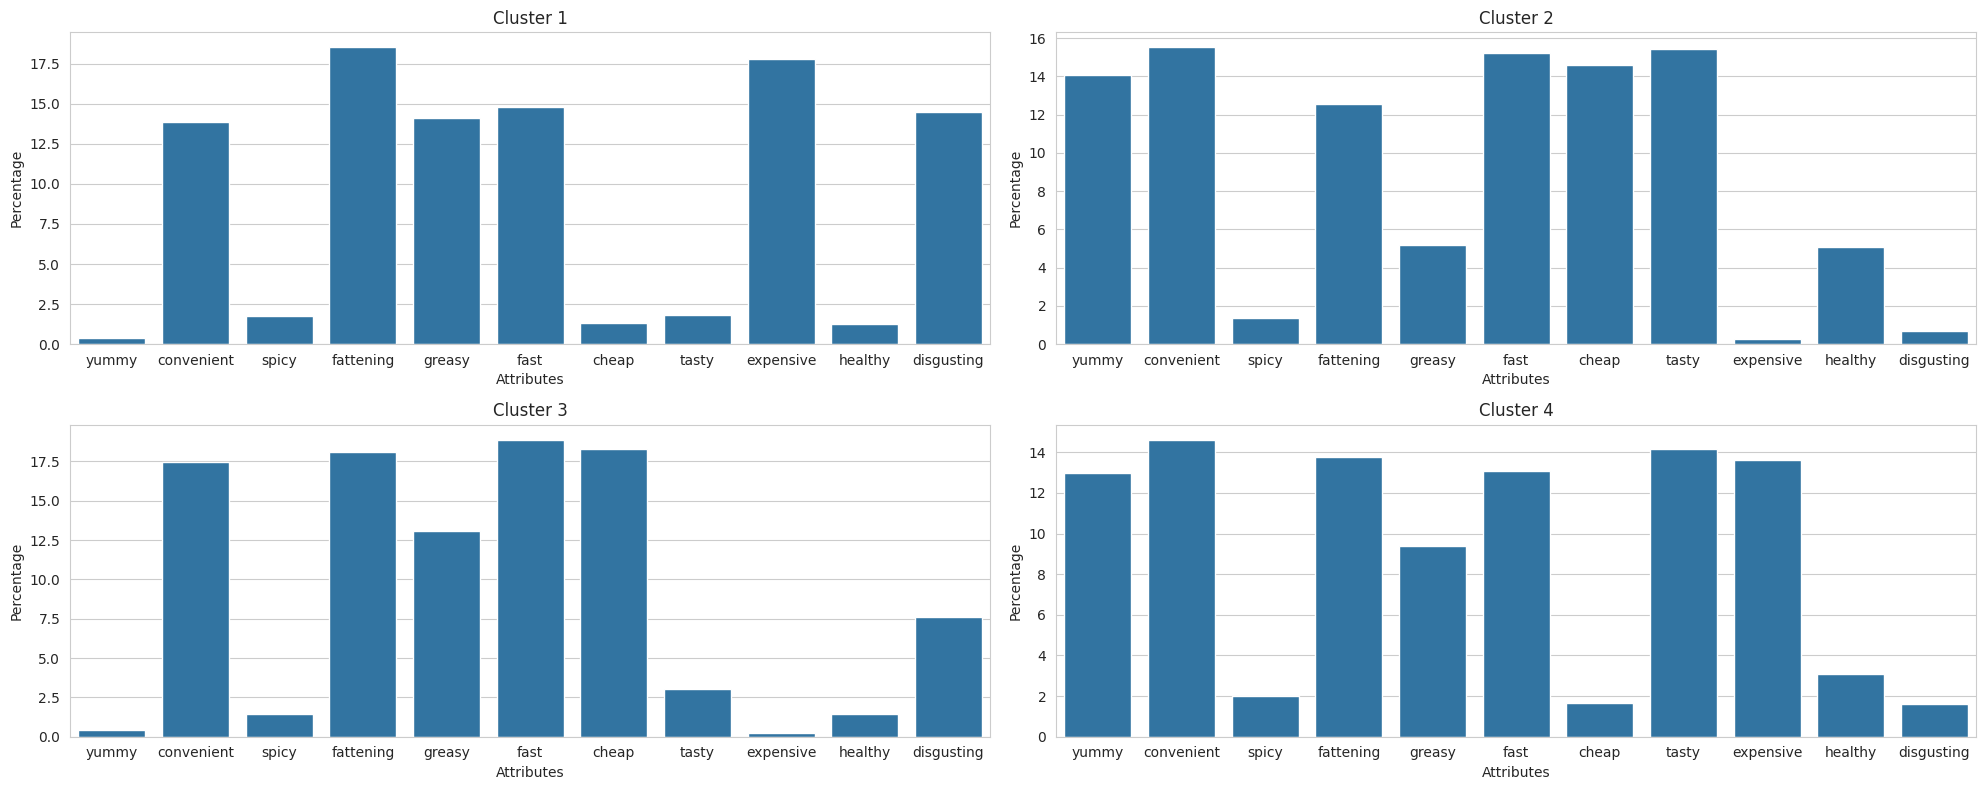

In [ ]:
stats_cluster_0 = np.sum(cluster_0, axis = 0)*100/np.sum(np.sum(cluster_0, axis = 0))
stats_cluster_1 = np.sum(cluster_1, axis = 0)*100/np.sum(np.sum(cluster_1, axis = 0))
stats_cluster_2 = np.sum(cluster_2, axis = 0)*100/np.sum(np.sum(cluster_2, axis = 0))
stats_cluster_3 = np.sum(cluster_3, axis = 0)*100/np.sum(np.sum(cluster_3, axis = 0))

fig,ax = plt.subplots(figsize = (20,8), nrows = 2, ncols = 2)
sns.barplot(stats_cluster_0, ax = ax[0][0])

ax[0][0].set_title('Cluster 1')
ax[0][0].set_xlabel('Attributes')
ax[0][0].set_ylabel('Percentage')

sns.barplot(stats_cluster_1, ax = ax[0][1])


ax[0][1].set_title('Cluster 2')
ax[0][1].set_xlabel('Attributes')
ax[0][1].set_ylabel('Percentage')

sns.barplot(stats_cluster_2, ax = ax[1][0])


ax[1][0].set_title('Cluster 3')
ax[1][0].set_xlabel('Attributes')
ax[1][0].set_ylabel('Percentage')

sns.barplot(stats_cluster_3, ax = ax[1][1])


ax[1][1].set_title('Cluster 4')
ax[1][1].set_xlabel('Attributes')
ax[1][1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()


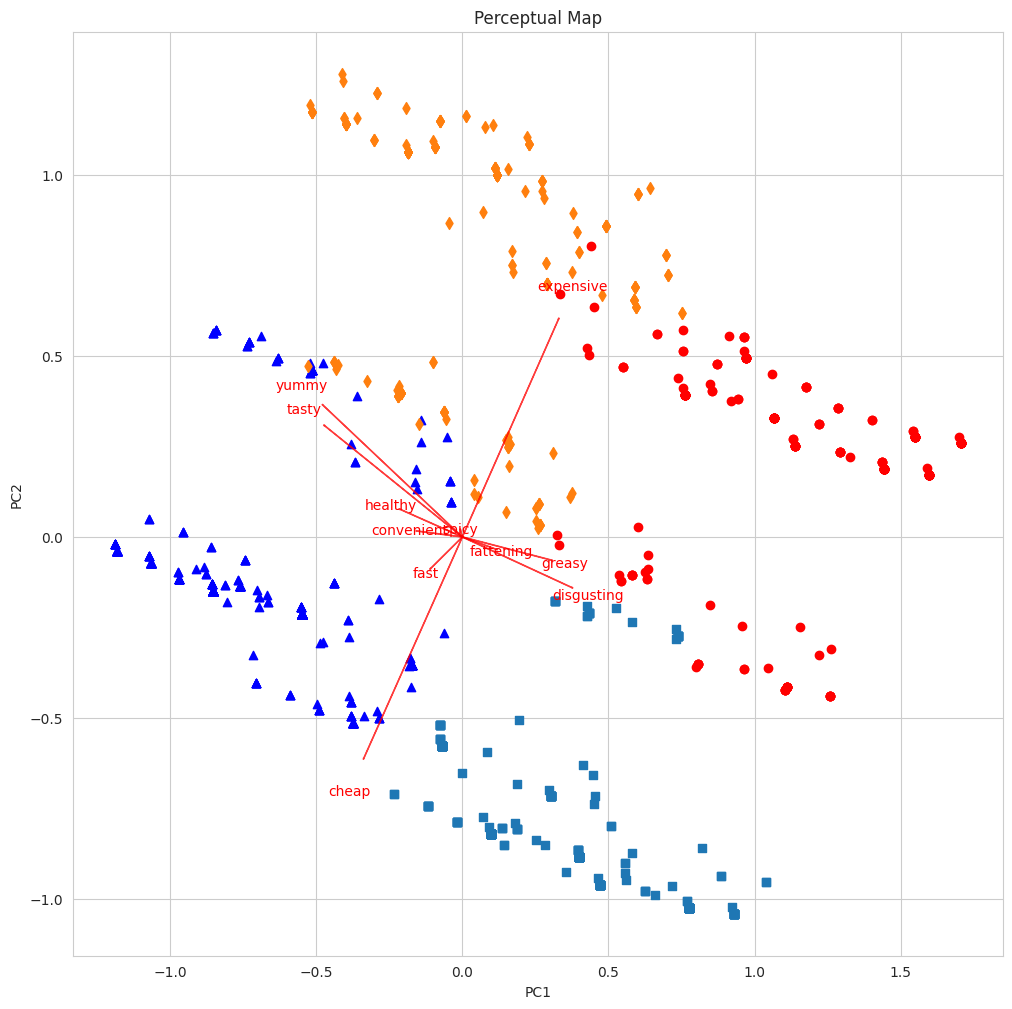

In [ ]:
pca_model = PCA(n_components = 2)
pca_result = pca_model.fit_transform(matrix.drop(columns = ['labels']))
okk = pd.DataFrame(zip(pca_result,matrix['labels']))
fig,ax = plt.subplots(figsize = (12,12))
ax.set_title('Perceptual Map')
cluster_0 = okk[okk[1] == 0]
cluster_1 = okk[okk[1] == 1]
cluster_2 = okk[okk[1] == 2]
cluster_3 = okk[okk[1] == 3]

x_coordinates = [point[0] for point in cluster_0[0]]
y_coordinates = [point[1] for point in cluster_0[0]]
plt.scatter( x_coordinates, y_coordinates, color = 'r', marker = 'o')

x_coordinates = [point[0] for point in cluster_1[0]]
y_coordinates = [point[1] for point in cluster_1[0]]
plt.scatter( x_coordinates, y_coordinates, color = 'b', marker = '^')

x_coordinates = [point[0] for point in cluster_2[0]]
y_coordinates = [point[1] for point in cluster_2[0]]
plt.scatter( x_coordinates, y_coordinates, marker = 's')

x_coordinates = [point[0] for point in cluster_3[0]]
y_coordinates = [point[1] for point in cluster_3[0]]
plt.scatter( x_coordinates, y_coordinates, marker = 'd')


for i, (var, coef) in enumerate(zip(matrix.drop(columns = ['labels']).columns, components_coordinates)):
        plt.arrow(0, 0, coef[0], coef[1], color='r', alpha=0.7)
        plt.text(coef[0] * 1.15, coef[1] * 1.15, var, color='r', ha='center', va='center')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()